# Лаба 4

# Апроксимация граничных условий второго рода в методе конечных разностей на примере уравнения теплопроводности

## Необходимые импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import random as r
from enum import Enum

## Задача 1

Найти приближенное решение начально-краевой задачи для уравнения теплопроводности:

$$
\begin{cases}
    \dfrac {\partial u}{\partial t} = k \dfrac {\partial^2 u}{\partial x^2} + f(x, t), a < x < b, 0 < t \le T, \\
    u(a, t)=g_1(t), \dfrac {\partial u}{\partial t}(b, t)=g_2(t), 0 < t \le T, \\
    u(x, 0)=\phi(x), a \le x \le b. 
\end{cases} 
$$

In [2]:
class BoundaryCondition(Enum):
    FIRST = 1
    SECOND = 2
    
class Scheme(Enum):
    EXPLICIT = 1
    IMPLICIT = 2

In [3]:
def phi(x):
    return x**2

def g1(x):
    return 1

def g2(x):
    return 1

def f(x, t):
    return 0

In [4]:
a = -1
b = 1
k = 2
T = 0.1

### Явная схема

Схема решается последовательным нахождением элементов на слой выше текущего:

$$ C = \dfrac {\tau k} {h^2} $$

$$ u(x, t + \tau) = C \cdot u(x - h, t) + (1 - 2 \cdot C) \cdot u(x, t) + C \cdot u(x + h, t) + f(x, t) $$

Условие устойчивости:

$$  \tau < \dfrac {h^2}{2 \cdot k} $$

#### Первый метод аппроксимации ГУ 2-го рода (Неймана) для явной схемы

Аппроксимируем последний элемент слоя через разность назад:

$$ \dfrac {\partial u}{\partial x} = g_2(t) $$

$$\dfrac {\partial u}{\partial x} = \dfrac {u(x, t) - u(x - h, t)}{h} $$

Для ясности:

$$ x_N == u(x, t)$$
$$ x_{N+1} == u(x + h, t)$$
$$ x_{N-1} == u(x - h, t)$$

Отсюда:

$$ u(x, t) = g_2(t) \cdot h + u(x - h, t)$$

Порядок аппроксимации ГУ $ O(h) $

Порядок аппроксимации всей схемы $ O(h + \tau) $

#### Второй метод аппроксимации ГУ 2-го рода (Неймана) для явной схемы

Аппроксимируется следующей формулой:

$$ u(x, t + \tau) = C \cdot u(x - h, t) + (1 - 2 \cdot C) \cdot u(x, t) + C \cdot u(x + h, t) + f(x, t) $$

Проблема на лицо: мы аппроксимимруем $N$'ый элемент (по $x$), но в формуле присудствует $N + 1$

Для того чтобы решить это проблему вводится фиктивный $N + 1$ элемент и тот в свою очередь апппроксимируется центральной разностью:

$$ \dfrac {\partial u}{\partial x} = g_2(t)$$ 

$$ \dfrac {\partial u}{\partial x} = \dfrac {u(x + h, t) - u(x - h, t)}{2h} $$

$$ u(x + h, t) = 2 \cdot h \cdot g_2(t) + u(x - h, t) $$

Подставляем это в формулу выше и получаем порядок аппроксимации ГУ $ O(h^2) $

Порядок аппроксимации всей схемы $O(h^2 + \tau)$

In [5]:
def get_next_time_layer_element(x, matrix, j, i, tau, C, method_type):
    if method_type == BoundaryCondition.FIRST:
        return g2(tau * j) * h + matrix[j, -2] 
    elif method_type == BoundaryCondition.SECOND:
        return C * ((2 * h * g2(tau * j) + matrix[j, -2]) + matrix[j, -2]) + \
                                (1 - 2 * C) * matrix[j, -1] + f(x[i], tau * j)

    
def explicit_scheme(h, tau, Nx, Nt, method_type):
    C = tau * k/h**2
    matrix = np.zeros((Nt, Nx))
    x = np.linspace(a, b, Nx)
    matrix[0] = phi(x)
    matrix[..., 0] = g1(np.linspace(0, T, Nt))
    for j in range(Nt - 1):
        for i in range(1, Nx - 1):
            matrix[j + 1, i] = \
                C * (matrix[j, i + 1] + matrix[j, i - 1]) + (1 - 2 * C) * matrix[j, i] + f(x[i], tau * j)
        matrix[j + 1, -1] = get_next_time_layer_element(x, matrix, j, i, tau, C, method_type)
    return matrix

### Неявная схема

Является безусловно-устойчивой (т.е. сходимость не зависит от выбранного $\tau$)

Общая вид схемы будет такой:

$$  -C \cdot u(x - h, t) + (1 + 2 \cdot C) \cdot u(x, t) + -C \cdot u(x + h, t) = u(x, t - \tau) + \tau \cdot f(x, t) $$

Главное отличие в решении неявной схемы является то, что мы находим не один элемент, а сразу всю строчку текущего временного слоя, используя значения из предыдущего и для этого для начала решается матричное уравнение следующего вида:

$$ A \overline x = \overline B $$

Где:

$A$ - диагональная матрица коэффициентов $-C; (1 + 2C); -C$ в которой первый слой имеет вид $[1, ..., 0]$, а последний в зависимости от метода аппроксимации ГУ;

$x$ - вектор, представляющий из себя слой который мы ищем;

$B$ - вектор, представляющий из себя правую часть общего вида схемы, при этом первый элемент равен $g_1(t)$, а последний, в зависимости от метода аппроксимации ГУ.

Решая это уравнение мы последовательно находим каждый временной слой матрицы.

#### Первый метод аппроксимации ГУ 2-го рода (Неймана) для неявной схемы

Аппроксимируем разностью назад:

$$ -u(x - h, t) + u(x, t) = h \cdot g_2(t) $$

Отсюда последний слой матрицы $A$ имеет вид:

$$ [0, ..., -1, 1] $$

Последний элемент вектора $B$ будет равен соответсвенно $ h \cdot g_2(t) $

#### Второй метод аппроксимации ГУ 2-го рода (Неймана) для неявной схемы

Логика аналогична перовму методу и аппроксимации явной схемы, отсюда слой матрицы $A$ имеет вид:

$$ [0, ..., -1, 0, 1] $$

Последний элемент вектора $B$ будет равен $2 \cdot h \cdot g_2(t)$ 

In [6]:
def get_c_matrix(C, N, method_type):
    matrix = np.zeros((N, N))
    if method_type == BoundaryCondition.FIRST:
        matrix[-1, -1] = 1
        matrix[-1, -2] = -1
    elif method_type == BoundaryCondition.SECOND:
        matrix[-1, -1] = 1
        matrix[-1, -2] = 0
        matrix[-1, -3] = -1
    matrix[0, 0] = 1
    for i in range(1, N - 1):
        matrix[i, i + 1] = matrix[i, i - 1] = -C
        matrix[i, i] = 1 + 2 * C
    return matrix


def implicit_scheme(h, tau, Nx, Nt, method_type):
    C = tau * k/h**2
    c_matrix = get_c_matrix(
        C,
        Nx if method_type == BoundaryCondition.FIRST else Nx + 1,
        method_type
    )
    matrix = np.zeros((Nt, Nx))
    x = np.linspace(a, b, Nx)
    matrix[0] = phi(x)
    for j in range(1, Nt):
        if method_type == BoundaryCondition.FIRST:
            vector = np.zeros(Nx)
            vector[0] = g1(0)
            vector[-1] = g2(T) * h
            vector[1:-1] = [matrix[j - 1, i] + tau * f(i, j) for i in range(1, Nx - 1)]
            matrix[j] = np.linalg.solve(c_matrix, vector)
        elif method_type == BoundaryCondition.SECOND:
            vector = np.zeros(Nx + 1)
            vector[0] = g1(0)
            vector[-1] = 2 * h * g2(T)
            vector[1:-1] = [matrix[j - 1, i] + tau * f(i, j) for i in range(1, Nx)]
            matrix[j] = np.linalg.solve(c_matrix, vector)[:-1]
    return matrix

### Графики

In [7]:
h = 0.09
tau = h**2 / (2*k) / 1.5
print(f"h = {h}", f"\u03C4 = {tau}")

h = 0.09 τ = 0.0013499999999999999


In [8]:
Nx = int((b - a) / h) + 1
Nt = int(T / tau) + 1 
print(f"Nx = {Nx}", f"Nt = {Nt}")

Nx = 23 Nt = 75


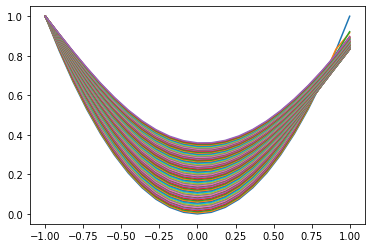

In [9]:
x = np.linspace(a, b, Nx)
y = explicit_scheme(h, tau, Nx, Nt, BoundaryCondition.FIRST)
for i in range(Nt):
    plot.plot(x, y[i])

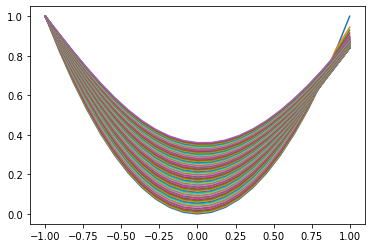

In [10]:
y = explicit_scheme(h, tau, Nx, Nt, BoundaryCondition.SECOND)
for i in range(Nt):
    plot.plot(x, y[i])

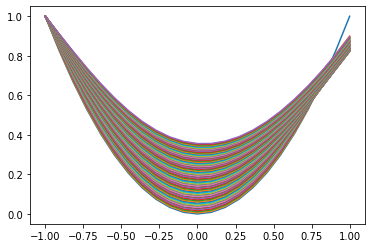

In [11]:
y = implicit_scheme(h, tau, Nx, Nt, BoundaryCondition.FIRST)
for i in range(Nt):
    plot.plot(x, y[i])

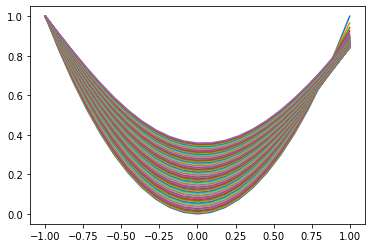

In [12]:
y = implicit_scheme(h, tau, Nx, Nt, BoundaryCondition.SECOND)
for i in range(Nt):
    plot.plot(x, y[i])

## Отчет 

In [13]:
def s_t(Nx, time_layer, first_solution, second_solution):
    local_sum = sum((second_solution[2 * time_layer, i] - first_solution[time_layer, i])**2 for i in range(Nx))
    return np.sqrt(local_sum)


def s_h(time_layer, first_solution, second_solution):
    local_sum = sum((second_solution[time_layer, 2 * i] - first_solution[time_layer, i])**2 for i in range(len(first_solution[time_layer])))
    return np.sqrt(local_sum)


def mod_t(Nx, time_layer, first_solution, second_solution):
    return max(abs(second_solution[2 * time_layer, i] - first_solution[time_layer, i]) for i in range(Nx))


def mod_h(time_layer, first_solution, second_solution):
    return max(abs(second_solution[time_layer, 2 * i] - first_solution[time_layer, i]) for i in range(len(first_solution[time_layer])))


def get_report_for_fixed_h(h, taus, scheme_type, method_type):
    Nx = int((b - a) / h) + 1
    solutions = []
    for tau in taus:
        Nt = int(T / tau) + 1
        if scheme_type == Scheme.EXPLICIT:
            if method_type == BoundaryCondition.FIRST:
                solutions.append(explicit_scheme(h, tau, Nx, Nt, method_type))
            elif method_type == BoundaryCondition.SECOND:
                solutions.append(explicit_scheme(h, tau, Nx, Nt, method_type))
        elif scheme_type == Scheme.IMPLICIT:
            if method_type == BoundaryCondition.FIRST:
                solutions.append(implicit_scheme(h, tau, Nx, Nt, method_type))
            elif method_type == BoundaryCondition.SECOND:
                solutions.append(implicit_scheme(h, tau, Nx, Nt, method_type))
    s_tn1 = []
    s_tn2 = []
    mod_tn1 = []
    mod_tn2 = []
    for solution1, solution2 in zip(solutions, solutions[1:]):
        s_tn1.append(s_t(Nx, tn1, solution1, solution2))
        s_tn2.append(s_t(Nx, tn2, solution1, solution2))
        mod_tn1.append(mod_t(Nx, tn1, solution1, solution2))
        mod_tn2.append(mod_t(Nx, tn2, solution1, solution2))
    return {
        "s_tn1": s_tn1 + [None],
        "s_tn2": s_tn2 + [None],
        "mod_tn1": mod_tn1 + [None],
        "mod_tn2": mod_tn2 + [None]
    }


def get_report_for_fixed_tau(tau, hs, scheme_type, method_type):
    Nt = int(T / tau) + 1
    solutions = []
    for h in hs:
        Nx = int((b - a) / h) + 1
        if scheme_type == Scheme.EXPLICIT:
            if method_type == BoundaryCondition.FIRST:
                solutions.append(explicit_scheme(h, tau, Nx, Nt, method_type))
            elif method_type == BoundaryCondition.SECOND:
                solutions.append(explicit_scheme(h, tau, Nx, Nt, method_type))
        elif scheme_type == Scheme.IMPLICIT:
            if method_type == BoundaryCondition.FIRST:
                solutions.append(implicit_scheme(h, tau, Nx, Nt, method_type))
            elif method_type == BoundaryCondition.SECOND:
                solutions.append(implicit_scheme(h, tau, Nx, Nt, method_type))
    s_tn1 = []
    s_tn2 = []
    mod_tn1 = []
    mod_tn2 = []
    for solution1, solution2 in zip(solutions, solutions[1:]):
        s_tn1.append(s_h(tn1, solution1, solution2))
        s_tn2.append(s_h(tn2, solution1, solution2))
        mod_tn1.append(mod_h(tn1, solution1, solution2))
        mod_tn2.append(mod_h(tn2, solution1, solution2))
    return {
        "s_tn1": s_tn1 + [None],
        "s_tn2": s_tn2 + [None],
        "mod_tn1": mod_tn1 + [None],
        "mod_tn2": mod_tn2 + [None]
    }

In [14]:
h = 0.15
tau = h**2 / (2*k) / 1.5
tn1 = int(T / tau)
tn2 = tn1 - 1
test_amount = r.randint(3, 5)
test_h = [h]
test_tau = [tau]
for i in range(test_amount - 1):
    test_h.append(test_h[i] / 2)
    test_tau.append(test_tau[i] / 2)

In [28]:
report = get_report_for_fixed_h(
    test_h[0],
    test_tau,
    Scheme.EXPLICIT,
    BoundaryCondition.FIRST
)
print("\nFIXED=h, SCHEMA=EXPLICIT, METHOD=FIRST")
pd.DataFrame({
    'h': [test_h[0] for _ in range(test_amount)],
    '\u03C4': test_tau,
    's(tn1)': report["s_tn1"],
    's(tn2)': report["s_tn2"],
    'max(mod(tn1))': report["mod_tn1"],
    'max(mod(tn2))': report["mod_tn2"]
})


FIXED=h, SCHEMA=EXPLICIT, METHOD=FIRST


,h,τ,s(tn1),s(tn2),max(mod(tn1)),max(mod(tn2))
0,0.15,0.003750,0.008525,0.008571,0.003345,0.003456
1,0.15,0.001875,0.006533,0.006708,0.003139,0.003286
2,0.15,0.000937,0.004786,0.004863,0.002873,0.002962
3,0.15,0.000469,NaN,NaN,NaN,NaN


In [29]:
report = get_report_for_fixed_h(
    test_h[0],
    test_tau,
    Scheme.EXPLICIT,
    BoundaryCondition.SECOND
)
print("\nFIXED=h, SCHEMA=EXPLICIT, METHOD=SECOND")
pd.DataFrame({
    'h': [test_h[0] for _ in range(test_amount)],
    '\u03C4': test_tau,
    's(tn1)': report["s_tn1"],
    's(tn2)': report["s_tn2"],
    'max(mod(tn1))': report["mod_tn1"],
    'max(mod(tn2))': report["mod_tn2"]
})


FIXED=h, SCHEMA=EXPLICIT, METHOD=SECOND


,h,τ,s(tn1),s(tn2),max(mod(tn1)),max(mod(tn2))
0,0.15,0.003750,0.003736,0.003755,0.001481,0.001472
1,0.15,0.001875,0.001823,0.001822,0.000935,0.000956
2,0.15,0.000937,0.001003,0.001015,0.000702,0.000720
3,0.15,0.000469,NaN,NaN,NaN,NaN


In [34]:
report = get_report_for_fixed_h(
    test_h[0],
    test_tau,
    Scheme.IMPLICIT,
    BoundaryCondition.FIRST
)
print("\nFIXED=h, SCHEMA=IMPLICIT, METHOD=FIRST")
pd.DataFrame({
    'h': [test_h[0] for _ in range(test_amount)],
    '\u03C4': test_tau,
    's(tn1)': report["s_tn1"],
    's(tn2)': report["s_tn2"],
    'max(mod(tn1))': report["mod_tn1"],
    'max(mod(tn2))': report["mod_tn2"]
})


FIXED=h, SCHEMA=IMPLICIT, METHOD=FIRST


,h,τ,s(tn1),s(tn2),max(mod(tn1)),max(mod(tn2))
0,0.15,0.003750,0.003284,0.003305,0.001332,0.001325
1,0.15,0.001875,0.001655,0.001650,0.000716,0.000729
2,0.15,0.000937,0.000851,0.000856,0.000480,0.000487
3,0.15,0.000469,NaN,NaN,NaN,NaN


In [33]:
report = get_report_for_fixed_h(
    test_h[0],
    test_tau,
    Scheme.IMPLICIT,
    BoundaryCondition.SECOND
)
print("\nFIXED=h, SCHEMA=IMPLICIT, METHOD=SECOND")
pd.DataFrame({
    'h': [test_h[0] for _ in range(test_amount)],
    '\u03C4': test_tau,
    's(tn1)': report["s_tn1"],
    's(tn2)': report["s_tn2"],
    'max(mod(tn1))': report["mod_tn1"],
    'max(mod(tn2))': report["mod_tn2"]
})


FIXED=h, SCHEMA=IMPLICIT, METHOD=SECOND


,h,τ,s(tn1),s(tn2),max(mod(tn1)),max(mod(tn2))
0,0.15,0.003750,0.003571,0.003586,0.001393,0.001381
1,0.15,0.001875,0.001779,0.001777,0.000931,0.000952
2,0.15,0.000937,0.000982,0.000994,0.000706,0.000725
3,0.15,0.000469,NaN,NaN,NaN,NaN


In [30]:
report = get_report_for_fixed_tau(
    test_tau[0],
    test_h,
    Scheme.EXPLICIT,
    BoundaryCondition.FIRST
)
print("\nFIXED=\u03C4, SCHEMA=EXPLICIT, METHOD=FIRST")
pd.DataFrame({
    'h': test_h,
    '\u03C4': [test_tau[0] for _ in range(test_amount)],
    's(tn1)': report["s_tn1"],
    's(tn2)': report["s_tn2"],
    'max(mod(tn1))': report["mod_tn1"],
    'max(mod(tn2))': report["mod_tn2"]
})


FIXED=τ, SCHEMA=EXPLICIT, METHOD=FIRST


,h,τ,s(tn1),s(tn2),max(mod(tn1)),max(mod(tn2))
0,0.15000,0.00375,2.186488e+12,5.199637e+11,1.140989e+12,2.731025e+11
1,0.07500,0.00375,4.534683e+29,2.299661e+28,2.902928e+29,1.495757e+28
2,0.03750,0.00375,1.977857e+45,2.418479e+43,1.316852e+45,1.617493e+43
3,0.01875,0.00375,NaN,NaN,NaN,NaN


In [31]:
report = get_report_for_fixed_tau(
    test_tau[0],
    test_h,
    Scheme.EXPLICIT,
    BoundaryCondition.SECOND
)
print("\nFIXED=\u03C4, SCHEMA=EXPLICIT, METHOD=SECOND")
pd.DataFrame({
    'h': test_h,
    '\u03C4': [test_tau[0] for _ in range(test_amount)],
    's(tn1)': report["s_tn1"],
    's(tn2)': report["s_tn2"],
    'max(mod(tn1))': report["mod_tn1"],
    'max(mod(tn2))': report["mod_tn2"]
})


FIXED=τ, SCHEMA=EXPLICIT, METHOD=SECOND


,h,τ,s(tn1),s(tn2),max(mod(tn1)),max(mod(tn2))
0,0.15000,0.00375,1.058383e+13,2.473213e+12,6.983985e+12,1.644189e+12
1,0.07500,0.00375,5.353566e+31,2.659705e+30,4.053022e+31,2.030769e+30
2,0.03750,0.00375,1.078129e+48,1.294585e+46,7.460370e+47,9.026687e+45
3,0.01875,0.00375,NaN,NaN,NaN,NaN


In [32]:
report = get_report_for_fixed_tau(
    test_tau[0],
    test_h,
    Scheme.IMPLICIT,
    BoundaryCondition.FIRST
)
print("\nFIXED=\u03C4, SCHEMA=IMPLICIT, METHOD=FIRST")
pd.DataFrame({
    'h': test_h,
    '\u03C4': [test_tau[0] for _ in range(test_amount)],
    's(tn1)': report["s_tn1"],
    's(tn2)': report["s_tn2"],
    'max(mod(tn1))': report["mod_tn1"],
    'max(mod(tn2))': report["mod_tn2"]
})


FIXED=τ, SCHEMA=IMPLICIT, METHOD=FIRST


,h,τ,s(tn1),s(tn2),max(mod(tn1)),max(mod(tn2))
0,0.15000,0.00375,0.009917,0.009660,0.005964,0.005182
1,0.07500,0.00375,0.080565,0.079603,0.034922,0.034324
2,0.03750,0.00375,0.004437,0.004677,0.001077,0.001144
3,0.01875,0.00375,NaN,NaN,NaN,NaN


In [36]:
report = get_report_for_fixed_tau(
    test_tau[0],
    test_h,
    Scheme.IMPLICIT,
    BoundaryCondition.SECOND
)
print("\nFIXED=\u03C4, SCHEMA=IMPLICIT, METHOD=SECOND")
pd.DataFrame({
    'h': test_h,
    '\u03C4': [test_tau[0] for _ in range(test_amount)],
    's(tn1)': report["s_tn1"],
    's(tn2)': report["s_tn2"],
    'max(mod(tn1))': report["mod_tn1"],
    'max(mod(tn2))': report["mod_tn2"]
})


FIXED=τ, SCHEMA=IMPLICIT, METHOD=SECOND


,h,τ,s(tn1),s(tn2),max(mod(tn1)),max(mod(tn2))
0,0.15000,0.00375,0.005168,0.005261,0.002851,0.002921
1,0.07500,0.00375,0.085655,0.085492,0.033781,0.033618
2,0.03750,0.00375,0.000586,0.000596,0.000170,0.000174
3,0.01875,0.00375,NaN,NaN,NaN,NaN
